# Import libraries & data

In [209]:
import pandas as pd
import numpy as np
import random
import os

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose

import pycountry as pc

In [130]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

until_2021 = pd.read_csv(os.path.abspath(parent_path + '/data/GEDEvent_v22_1.csv'))
candidates = pd.read_csv(os.path.abspath(parent_path + '/data/candidates_120523.csv'))
ucdp_og = pd.concat([until_2021, candidates], ignore_index=True)

merged_og =  pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))
#gdelt_og = pd.read_csv(os.path.abspath(parent_path + '/data/final_merged_bycountry.txt'))#, sep="/")


/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_5143/1515431689.py:5: DtypeWarning:

Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_5143/1515431689.py:9: DtypeWarning:

Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
# Using merged rather than pure GDELT here

#geldet = merged_og.copy()

# Dop columns, e.g. event counts related to opp or gov being actor1 or actor2
#geldet.drop(columns=['year', 'month', 'Actor1Code_count', 'Actor1CountryCode_count', 'Actor1KnownGroupCode_count', 'Actor1Type1Code_count', 'Actor2Code_count', 'Actor2CountryCode_count', 'Actor2KnownGroupCode_count', 'Actor2Type1Code_count', 'AvgGoldsteinScale'], inplace=True, axis=1)
#columns_to_drop = [col for col in geldet.columns if col.endswith(("_gov", "_opp"))]
#geldet.drop(columns=columns_to_drop, inplace=True, axis=1)
#geldet = merged[merged['month_year'] >= '1989-01-01']

# Compare entries
Something is off with the MonthYear column (it seems to have some 1970 date attached to the beginning of each entry), so I generated a new one  called month_year.

In [161]:
ucdp = ucdp_og.copy()
merged = merged_og.copy()
merged = merged[merged['year'] >= 1989]

In [162]:
#ValueError: time data '2017-07-31 00:00:00.000' does not match format 'ISO8601' (match)
ucdp.date_start = pd.to_datetime(ucdp.date_start) #, format='ISO8601')
merged.MonthYear = pd.to_datetime(merged.MonthYear)

print('entires ucdp:', len(ucdp))
print('date range:', ucdp.date_start.min(), 'to', ucdp.date_start.max())
print('entires merged:', len(merged))
print('date range:', merged.year.min(), 'to', merged.year.max())
print('date range:', merged.MonthYear.min(), 'to', merged.MonthYear.max())

entires ucdp: 313838
date range: 1989-01-01 00:00:00 to 2023-03-31 00:00:00
entires merged: 92637
date range: 1989 to 2023
date range: 1970-01-01 00:00:00.000198901 to 1970-01-01 00:00:00.000202305


In [163]:
# Thought this would only be necessary for merged pre merge

merged['year'] = merged['year'].astype(str)
merged['month'] = merged['month'].astype(str)

# Pad the month column with leading zeros if needed (e.g., convert '1' to '01')
merged['month'] = merged['month'].str.zfill(2)

# Concatenate the year and month columns with a '-' &  convert to datetime object
merged['month_year'] = merged['year'] + '-' + merged['month']
merged['month_year'] = pd.to_datetime(merged['month_year'], format='%Y-%m')

merged[['month_year', 'MonthYear']].head(3)

,month_year,MonthYear
23666,1989-01-01,1970-01-01 00:00:00.000198901
23667,1989-01-01,1970-01-01 00:00:00.000198901
23668,1989-01-01,1970-01-01 00:00:00.000198901


In [170]:
print('entires ucdp:', len(ucdp))
print('date range:', ucdp.date_start.min(), 'to', ucdp.date_start.max())
print('entires merged:', len(merged))
print('date range:', merged.month_year.min(), 'to', merged.month_year.max())

entires ucdp: 313838
date range: 1989-01-01 00:00:00 to 2023-03-31 00:00:00
entires merged: 92637
date range: 1989-01-01 00:00:00 to 2023-05-01 00:00:00


# Inpsect country

In [171]:
ucdp.rename(columns={'best': 'deaths'}, inplace=True)
TARGET = "deaths"

## Choose country
Returns visulaisations of UCDP and Merged time series of
- monthly deaths and change in deaths
- monthly vs quarterly vs annual aggregation
- decomposition: trend & seasonality and accordinly extracted residuals

Main insight: doesn't really make sense to think of conflict in these time series terms.

In [240]:
# pick a random country

random_country = random.choice(merged.isocode.unique())
country_choice = pc.countries.get(alpha_3=random_country).name

print(country_choice, random_country)

# countries tried: 
# El Salvador SLV - intresting as has a single flare-up after almost 30 years of peace
# Guinea-Bissau GNB - small flare-up recently after confliect in late 90s


### NOT DATA in ucdp for these countries
# Chile CHL 
# Korea, Democratic People's Republic of PRK
# Cyprus CYP

United Kingdom GBR


United Kingdom
date range: 1989-01-25 00:00:00 to 2020-02-02 00:00:00
date range: 1989-01-01 00:00:00 to 2023-05-01 00:00:00
length ucdp pre resample: 199
length merged pre resample: 413
length ucdp post resample: 374
length merged post resample: 413


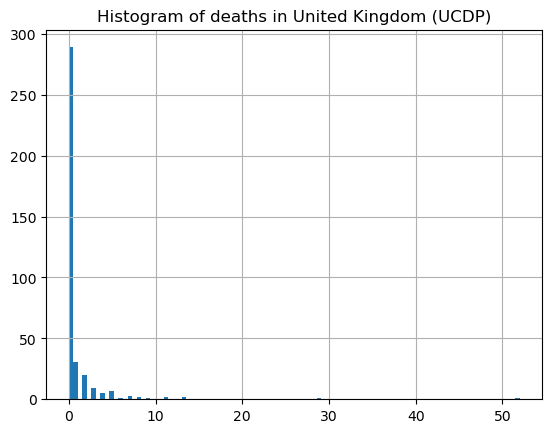

/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_5143/2608764201.py:42: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



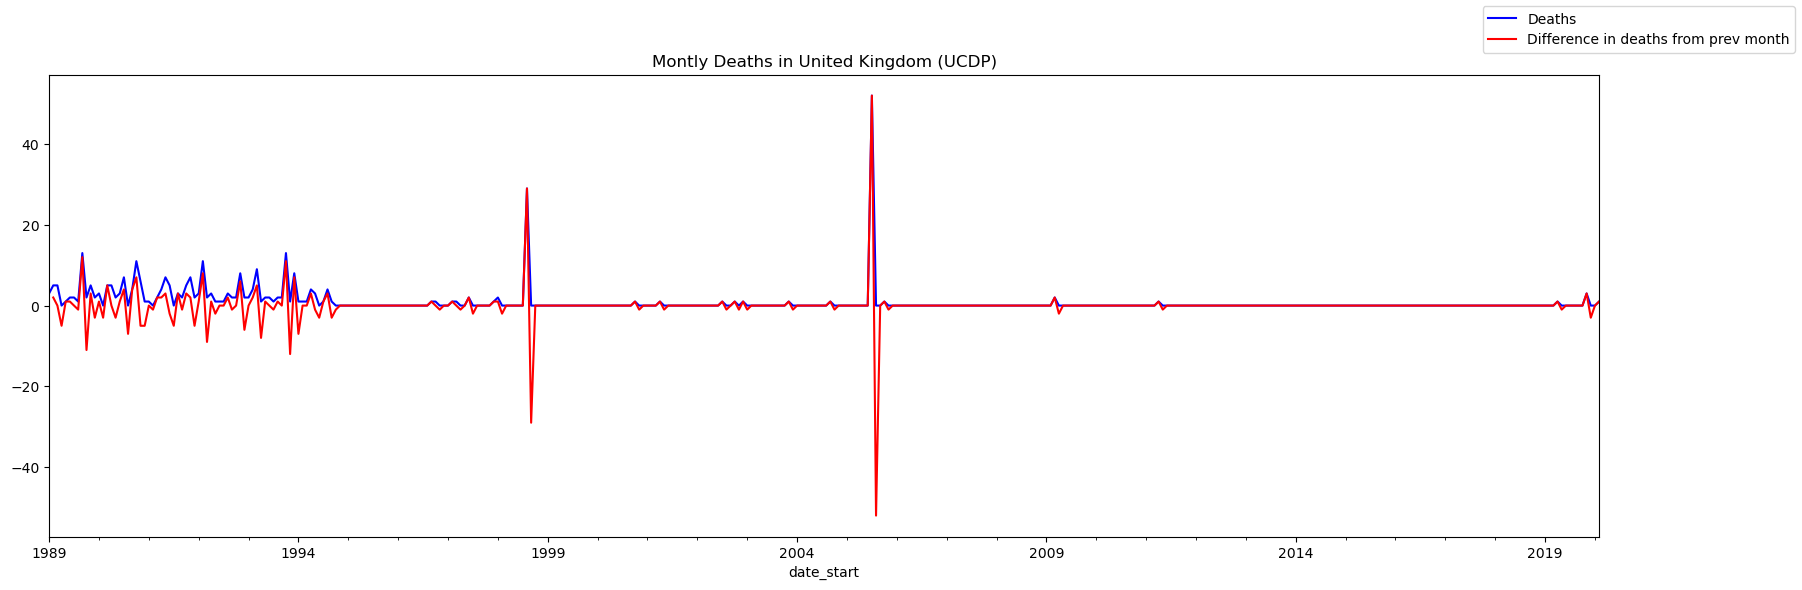

In [241]:
# choose country (can use the one picked by random choice above)
isocode_choice = random_country #'BFA' #'NIC'
country_choice = pc.countries.get(alpha_3=isocode_choice).name # 'Burkina Faso' 'Nicaragua'
print(country_choice)

# filter to country
ucdp_cntry = ucdp[ucdp['country']==country_choice]
merged_cntry = merged[merged['isocode']==isocode_choice]

# date range
print('date range:', ucdp_cntry.date_start.min(), 'to', ucdp_cntry.date_start.max())
print('date range:', merged_cntry.month_year.min(), 'to', merged_cntry.month_year.max())

# set index to date
ucdp_cntry = ucdp_cntry.set_index('date_start')
merged_cntry = merged_cntry.set_index('month_year')

# check length before resampling
print('length ucdp pre resample:', len(ucdp_cntry))
print('length merged pre resample:', len(merged_cntry))

# resample to monthly (for most countries, this is the same as the original data in the merged dataset)
ucdp_cntry = ucdp_cntry.resample('M')[[TARGET]].sum()
merged_cntry = merged_cntry.resample('M')[[TARGET]].sum()

# check length after resampling
print('length ucdp post resample:', len(ucdp_cntry))
print('length merged post resample:', len(merged_cntry))

# plot histogram of deaths (not so interesting for mered dataset as mostly zeros)
ucdp_cntry[TARGET].hist(bins=100)
plt.title(f'Histogram of deaths in {country_choice} (UCDP)')
plt.show()

# plot timeseries of deaths and the monthly change (pure difference, not percentage change) in deaths
#print(ucdp_cntry[TARGET].diff().mean().round(3)) # show mean monthly change
fig, ax = plt.subplots(figsize=(20, 6))
ax = ucdp_cntry[TARGET].plot(ax=ax, color='blue', label='Deaths')
ax = ucdp_cntry[TARGET].diff().plot(ax=ax, color='red', label='Difference in deaths from prev month')
plt.title(f'Montly Deaths in {country_choice} (UCDP)')
fig.legend()
fig.show()

# show timeseries of deaths that can be zoomed into
ix_start = int(np.random.uniform(0, ucdp_cntry.shape[0] - 1000))
ix_end = ix_start + 1000
_cntry_ts = ucdp_cntry.copy()#iloc[ix_start:ix_end]
px.line(_cntry_ts.reset_index(), x="date_start", y=TARGET, title=f"Montly Deaths in {country_choice} (UDCP)")

In [242]:
# show timeseries of deaths that can be zoomed into
ix_start = int(np.random.uniform(0, merged_cntry.shape[0] - 1000))
ix_end = ix_start + 1000
_cntry_ts = merged_cntry.copy()#iloc[ix_start:ix_end]
px.line(_cntry_ts.reset_index(), x="month_year", y=TARGET, title=f"Montly Deaths in {country_choice} (Merged Dataset)")

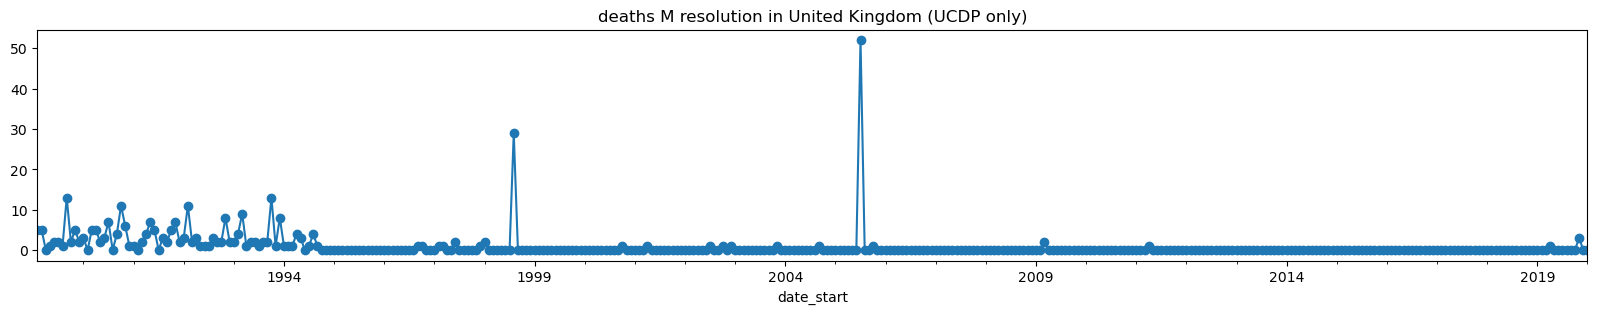

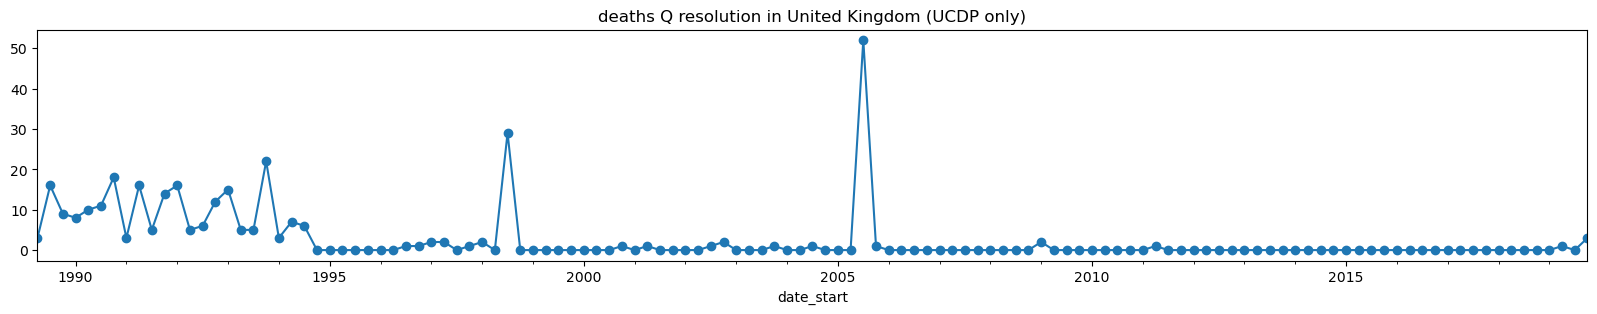

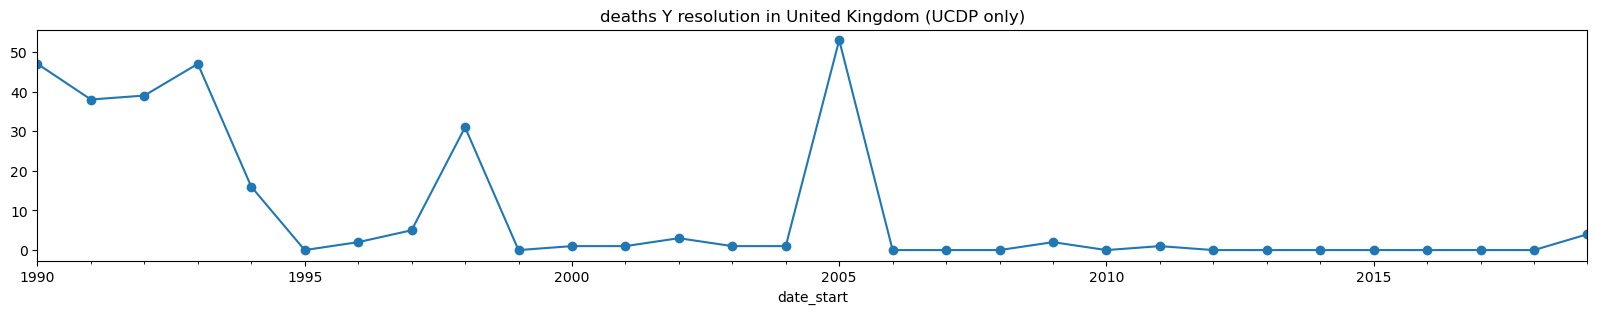

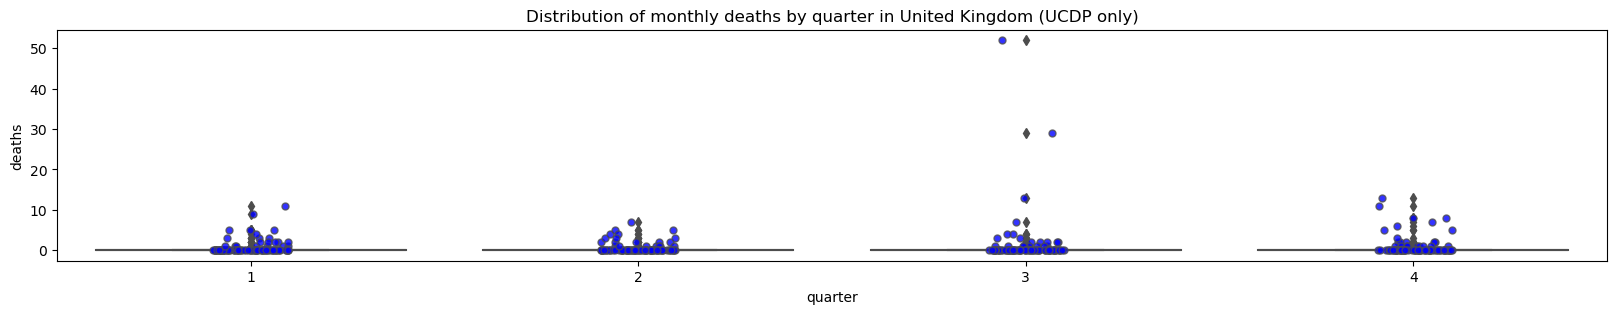

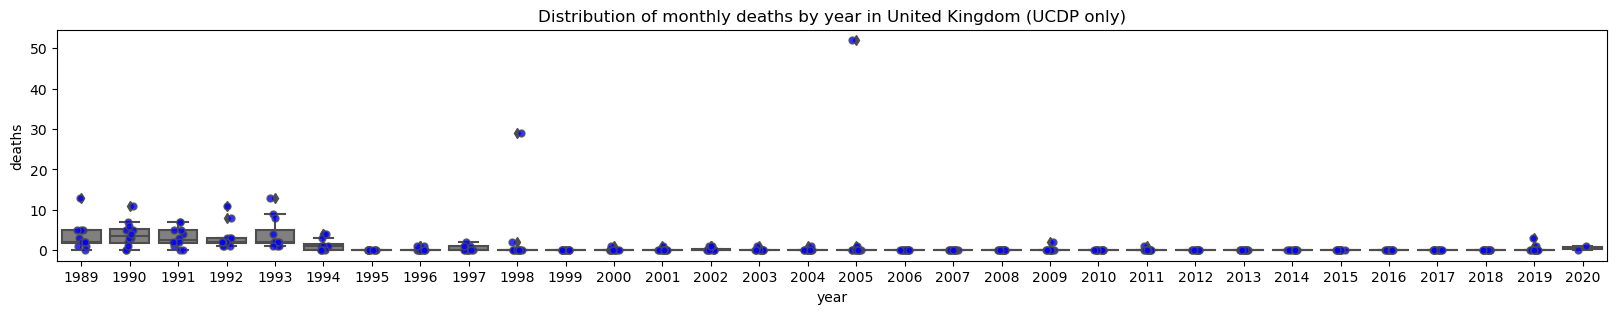

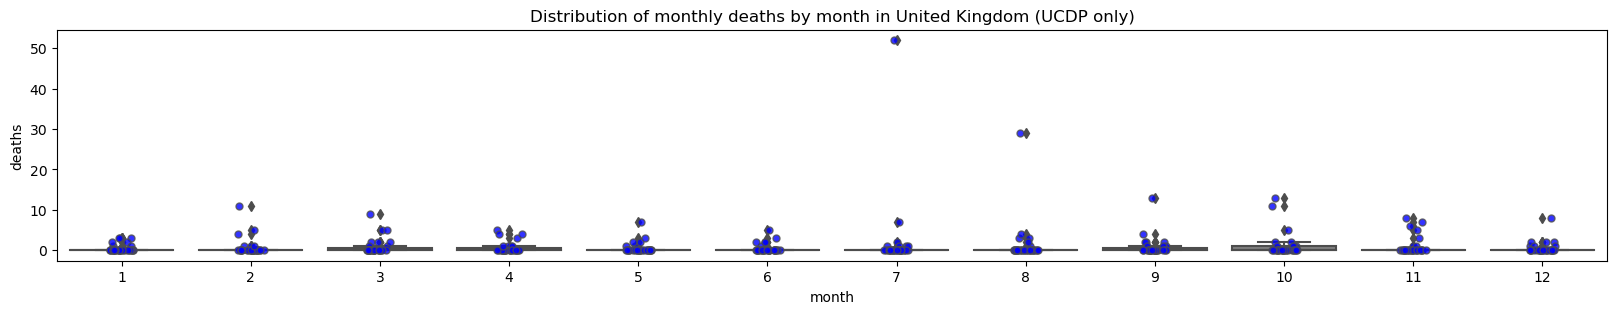

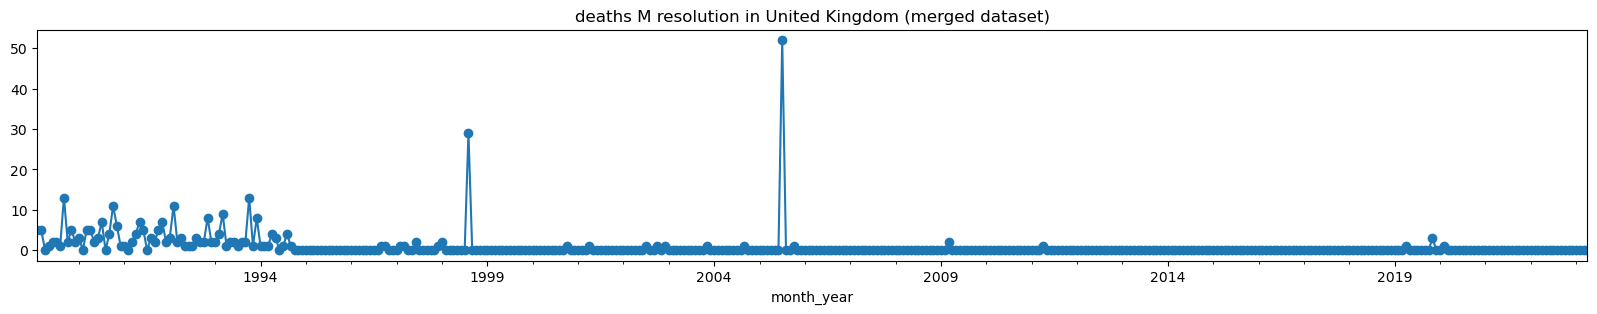

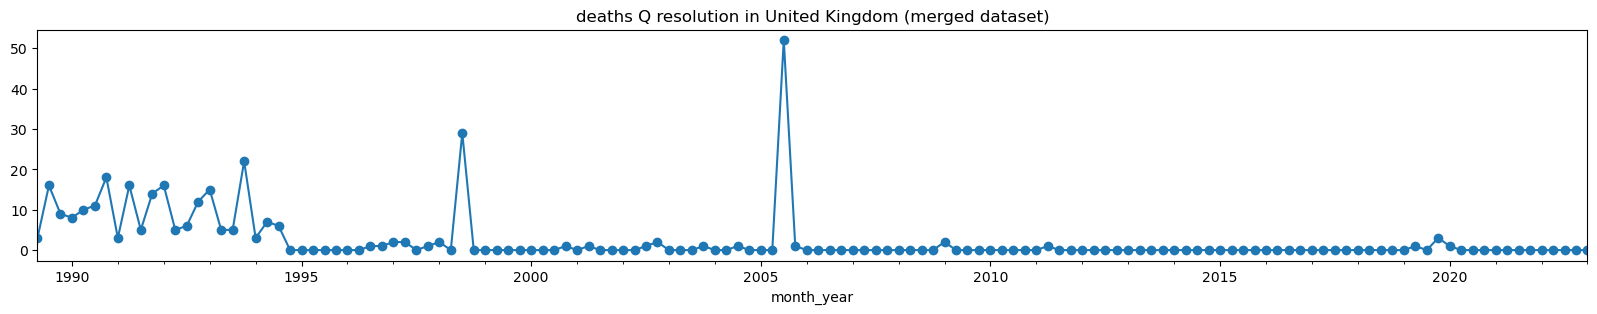

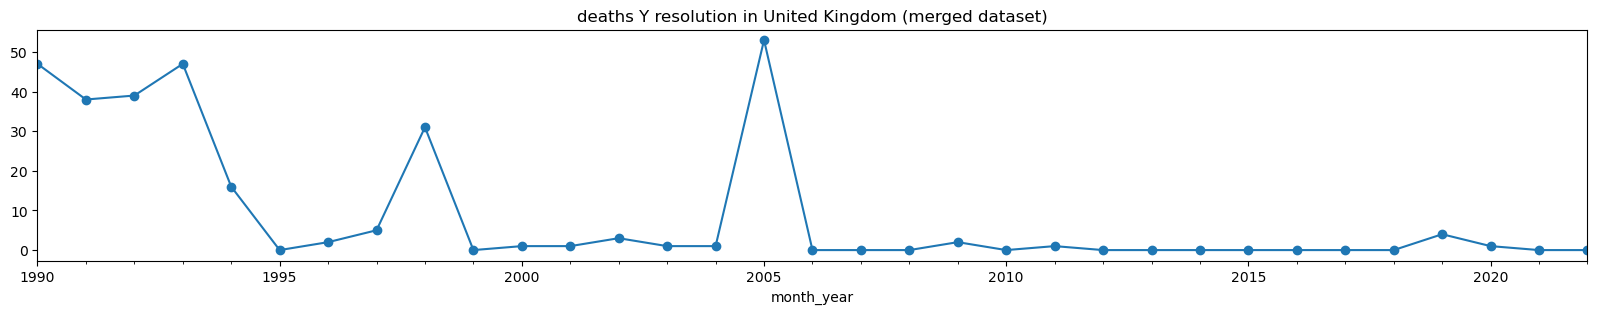

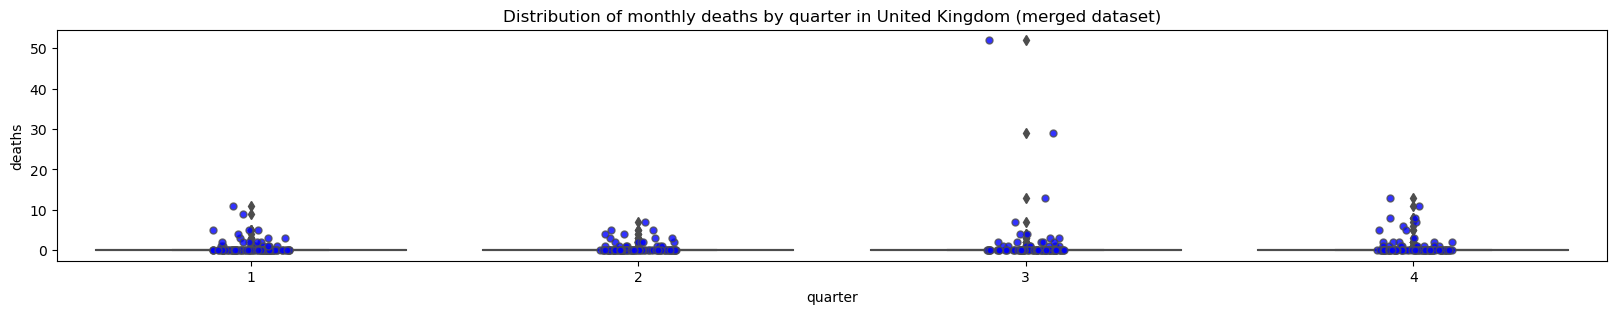

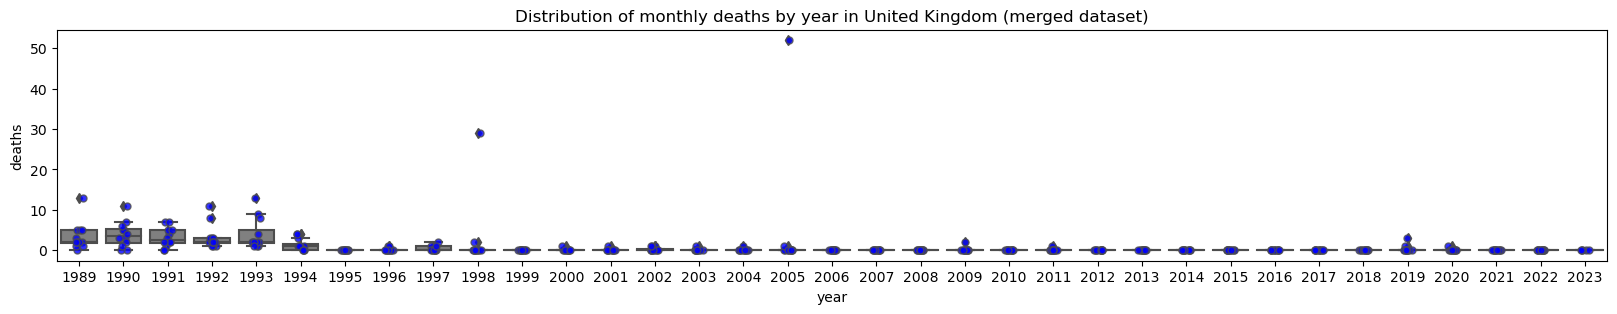

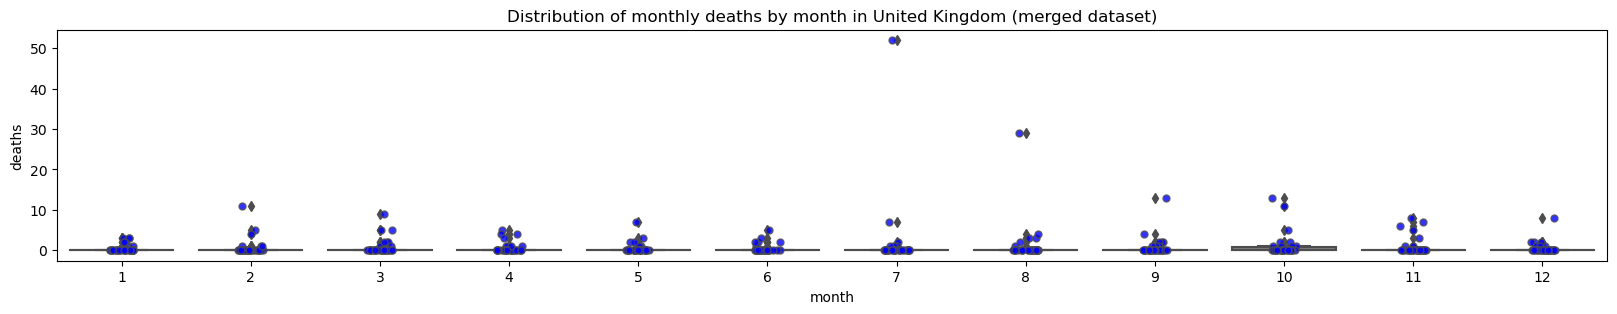

In [243]:
# For UCDP dataset- usually fewer time periods (as appears later or stops appearing)
for resolution in ['M', 'Q', 'Y']:
    fig, ax = plt.subplots(figsize=(20, 3))
    ucdp_cntry[TARGET].resample(resolution).sum().iloc[1:-1].plot(ax=ax, marker='o')
    ax.set_title(f'deaths {resolution} resolution in {country_choice} (UCDP only)')

ucdp_cntry['quarter'] = ucdp_cntry.index.quarter
ucdp_cntry['year'] = ucdp_cntry.index.year
ucdp_cntry['month'] = ucdp_cntry.index.month

time_features = ['quarter','year','month']
for f_name in time_features:
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.boxplot(x=f_name, y=TARGET, data=ucdp_cntry, ax=ax, color='grey')
    sns.stripplot(data=ucdp_cntry, x=f_name, y=TARGET, ax=ax, linewidth=1, color='b', alpha=.8)
    ax.set_title(f'Distribution of monthly deaths by {f_name} in {country_choice} (UCDP only)')


# For Merged dataset- More periods as left joined on GDELT
for resolution in ['M', 'Q', 'Y']:
    fig, ax = plt.subplots(figsize=(20, 3))
    merged_cntry[TARGET].resample(resolution).sum().iloc[1:-1].plot(ax=ax, marker='o')
    ax.set_title(f'deaths {resolution} resolution in {country_choice} (merged dataset)')

merged_cntry['quarter'] = merged_cntry.index.quarter
merged_cntry['year'] = merged_cntry.index.year
merged_cntry['month'] = merged_cntry.index.month

time_features = ['quarter','year','month']
for f_name in time_features:
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.boxplot(x=f_name, y=TARGET, data=merged_cntry, ax=ax, color='grey')
    sns.stripplot(data=merged_cntry, x=f_name, y=TARGET, ax=ax, linewidth=1, color='b', alpha=.8)
    ax.set_title(f'Distribution of monthly deaths by {f_name} in {country_choice} (merged dataset)')


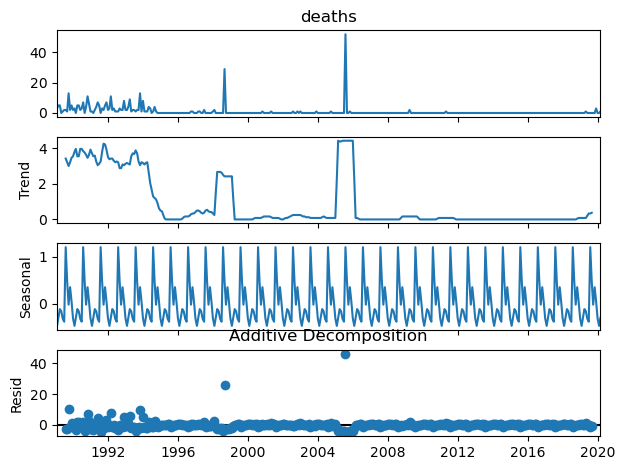

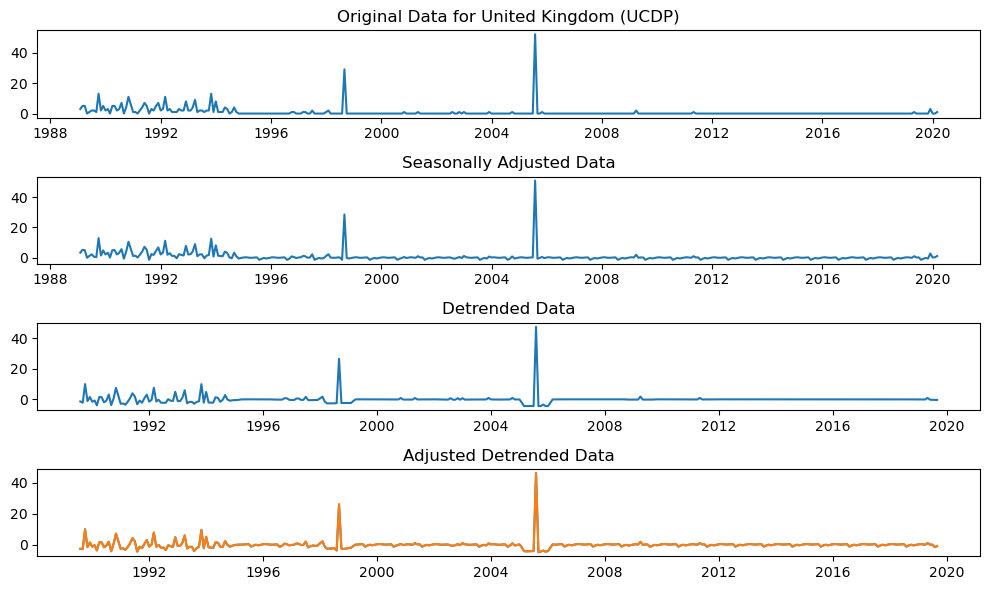

In [244]:
# Attempts to adjust for seasonality and trend in the data
# NB: Multiplicative seasonality is not appropriate for zero and negative values
decomposition = seasonal_decompose(ucdp_cntry[TARGET], model='additive')
decomposition.plot()
plt.title("Additive Decomposition")
plt.show()

# Get the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Calculate the seasonally adjusted data
seasonally_adjusted = ucdp_cntry[TARGET] - seasonal
detrended = ucdp_cntry[TARGET] - trend
adjusted_detrended = ucdp_cntry[TARGET] - trend - seasonal

# Plotting the original and seasonally adjusted data
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(ucdp_cntry[TARGET])
plt.title(f'Original Data for {country_choice} (UCDP)')

plt.subplot(4, 1, 2)
plt.plot(seasonally_adjusted)
plt.title('Seasonally Adjusted Data')

plt.subplot(4, 1, 3)
plt.plot(detrended)
plt.title('Detrended Data')

plt.subplot(4, 1, 4)
plt.plot(adjusted_detrended)
plt.plot(residual) # Residuals are the same as adjusted detrended data 
plt.title('Adjusted Detrended Data')

plt.tight_layout()
plt.show()

## Nigeria (older version - code above allows to choose any country)

In [176]:
ucdp_nigeria = ucdp[ucdp['country']=='Nigeria']

ucdp_nigeria = ucdp_nigeria.set_index('date_start')


print(ucdp_nigeria[TARGET].value_counts().value_counts().head(5))
ucdp_nigeria[[TARGET]].describe().round(2).T

1    56
2    18
5     7
3     5
4     5
Name: deaths, dtype: int64


,count,mean,std,min,25%,50%,75%,max
deaths,6513.0,10.43,44.95,0.0,1.0,3.0,8.0,2478.0


In [19]:
# Weekly data for Nigeria

# ucdp_nigeria_w = ucdp_nigeria.resample('W')[[TARGET]].sum()

# ucdp_nigeria_w['date'] = ucdp_nigeria_w.index.date
# print(ucdp_nigeria_w.shape)
# print(ucdp_nigeria_w.index.min(), ucdp_nigeria_w.index.max())
# print(ucdp_nigeria_w.head())
# print(ucdp_nigeria_w.describe().round(2).T)
# print(ucdp_nigeria_w['best'].value_counts().value_counts().head(10))
# ucdp_nigeria_w['best'].hist(bins=100)


1990-09-30 00:00:00 2023-03-31 00:00:00
(391, 2)
            deaths        date
date_start                    
1990-09-30       9  1990-09-30
1990-10-31      80  1990-10-31
1990-11-30       0  1990-11-30
1990-12-31       0  1990-12-31
1991-01-31       0  1991-01-31
        count    mean    std  min  25%   50%    75%     max
deaths  391.0  173.74  297.6  0.0  1.5  53.0  232.5  2525.0
1     154
2      31
4       6
3       6
6       3
5       2
84      1
14      1
7       1
Name: deaths, dtype: int64


<AxesSubplot:>

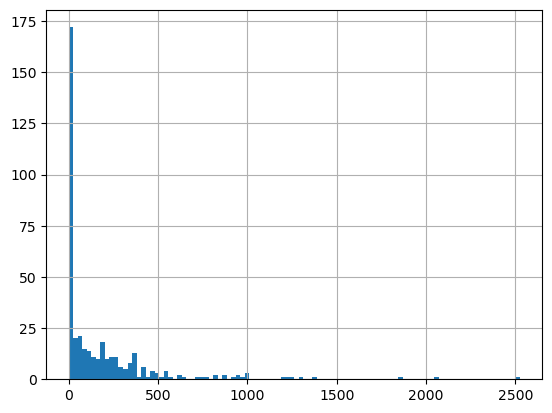

In [177]:
# Monthly data for Nigeria

ucdp_nigeria_m = ucdp_nigeria.resample('M')[[TARGET]].sum()

ucdp_nigeria_m['date'] = ucdp_nigeria_m.index.date
print(ucdp_nigeria_m.index.min(), ucdp_nigeria_m.index.max())
print(ucdp_nigeria_m.shape)
print(ucdp_nigeria_m.head())
print(ucdp_nigeria_m.describe().round(2).T)
print(ucdp_nigeria_m[TARGET].value_counts().value_counts())
ucdp_nigeria_m[TARGET].hist(bins=100)

In [33]:
ix_start = int(np.random.uniform(0, ucdp_nigeria_m.shape[0] - 1000))
ix_end = ix_start + 1000
_nigeria = ucdp_nigeria_m.copy()#iloc[ix_start:ix_end]
px.line(_nigeria.reset_index(), x="date_start", y="best", title="Montly Deaths in Nigeria")

1.638


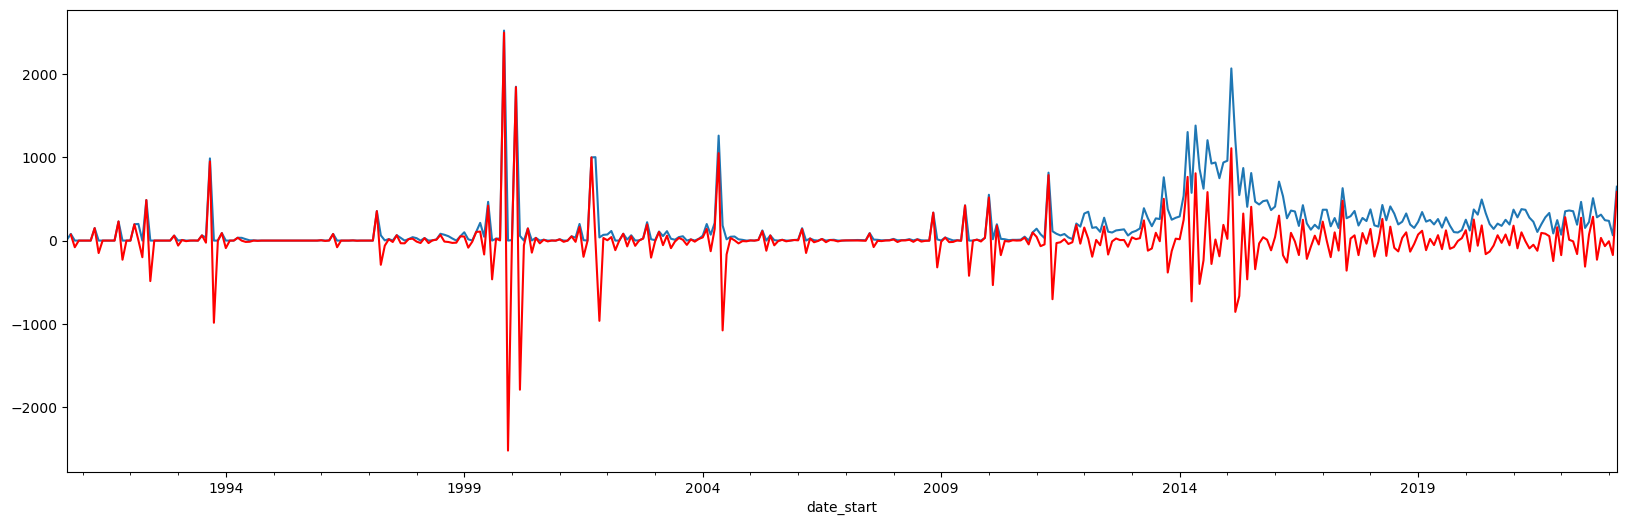

In [42]:
# Plotting month-on-month change alongside the original time series
# Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is element in previous row).

fig, ax = plt.subplots(figsize=(20, 6))
ax = ucdp_nigeria_m['best'].plot(ax=ax)
ax = ucdp_nigeria_m['best'].diff().plot(ax=ax, color='red')

print(ucdp_nigeria_m['best'].diff().mean().round(3))


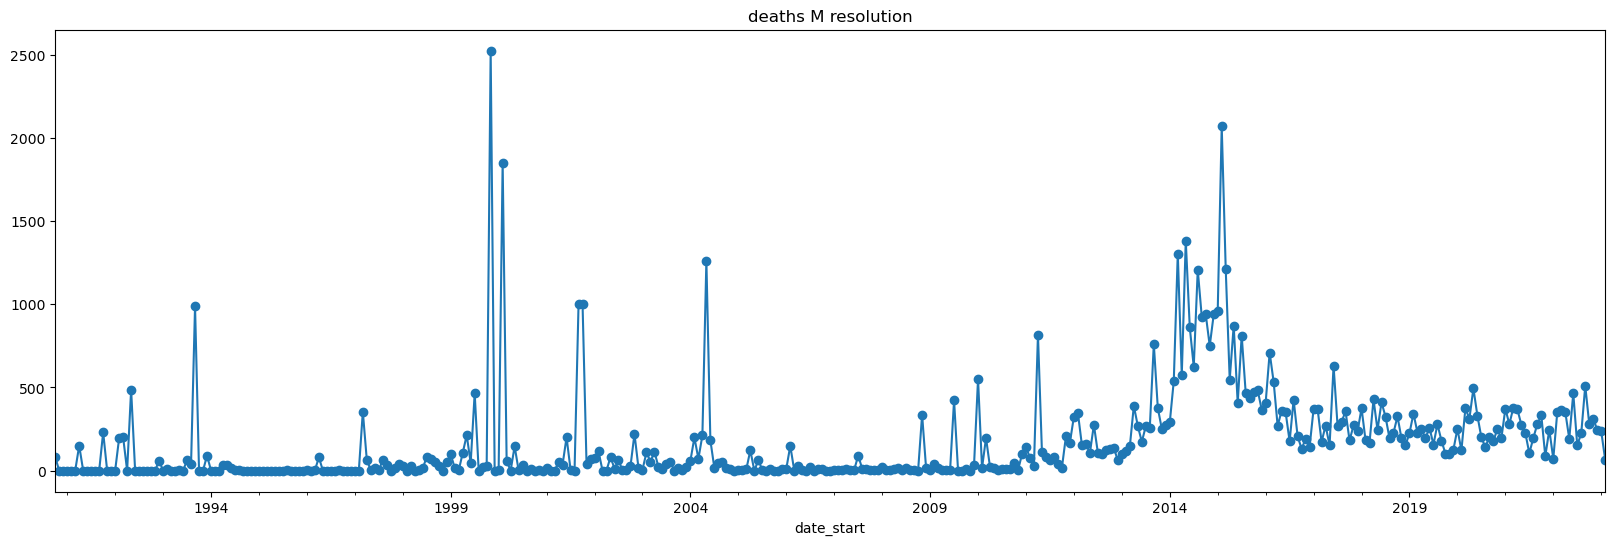

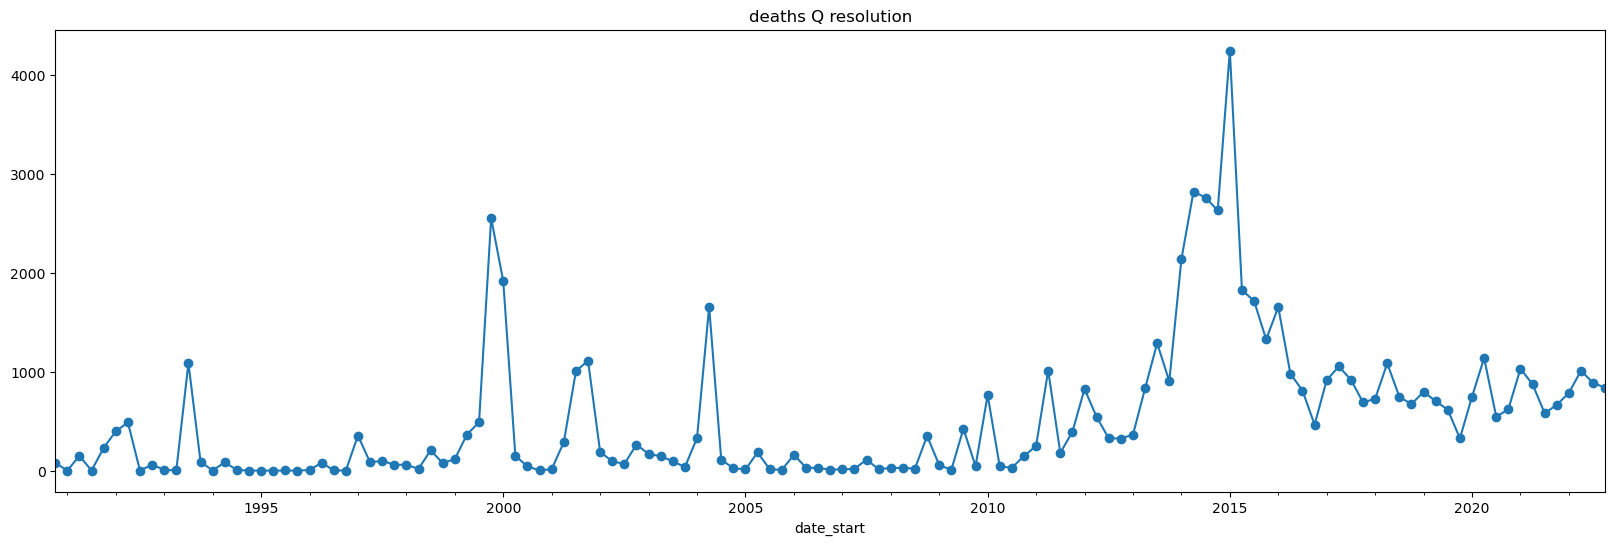

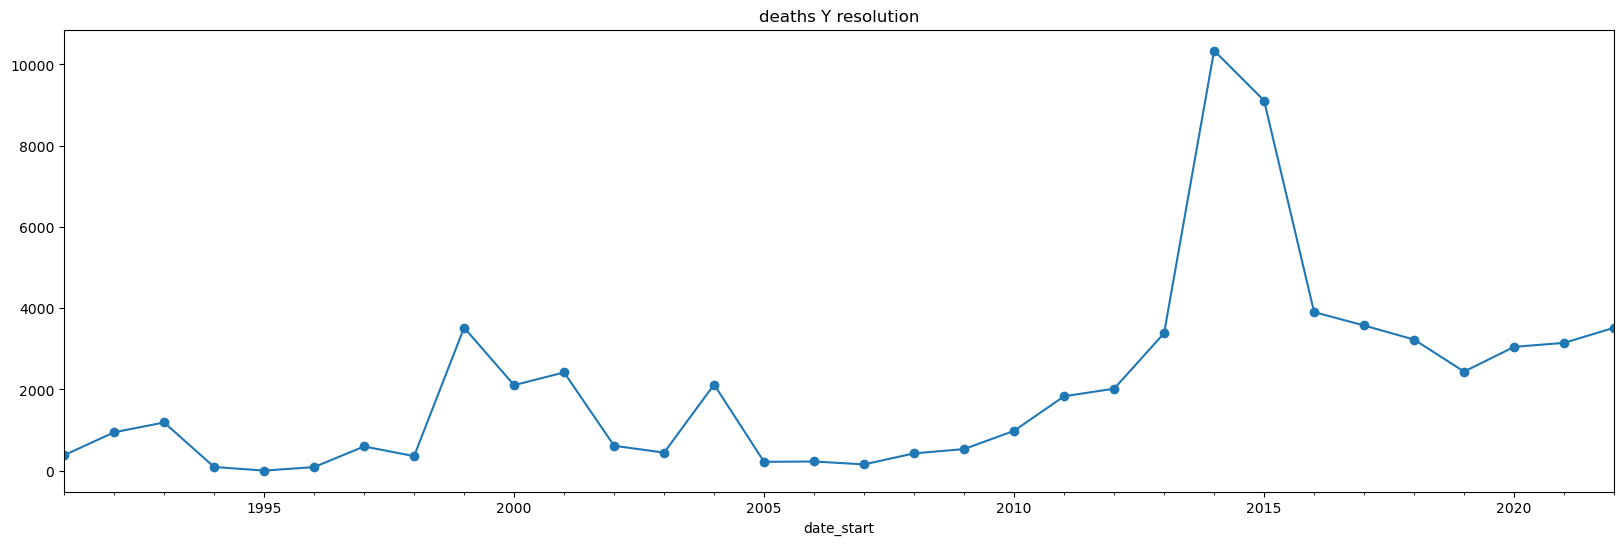

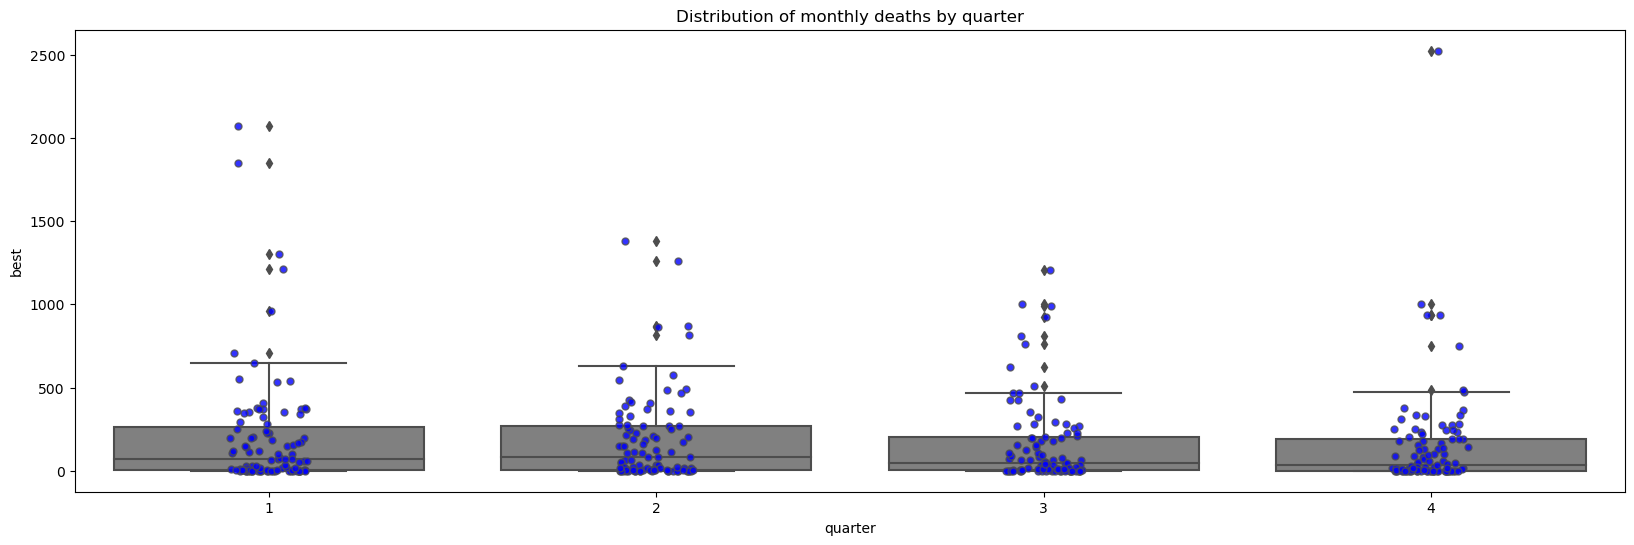

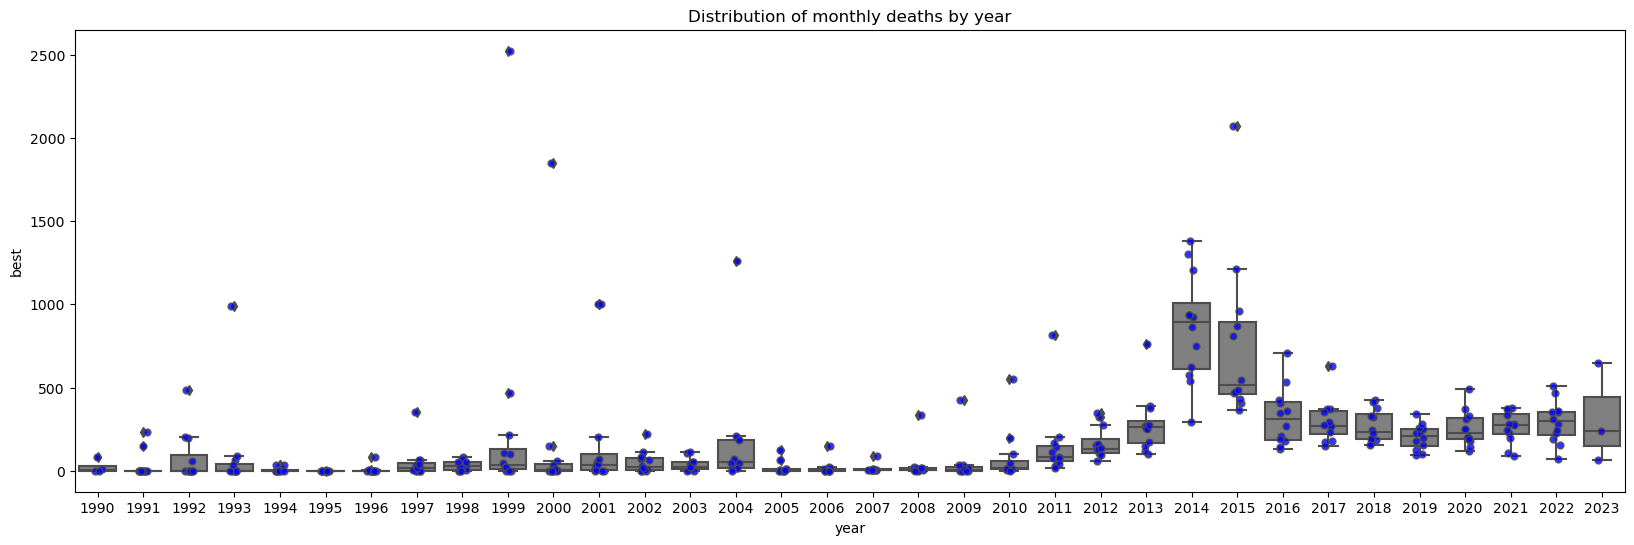

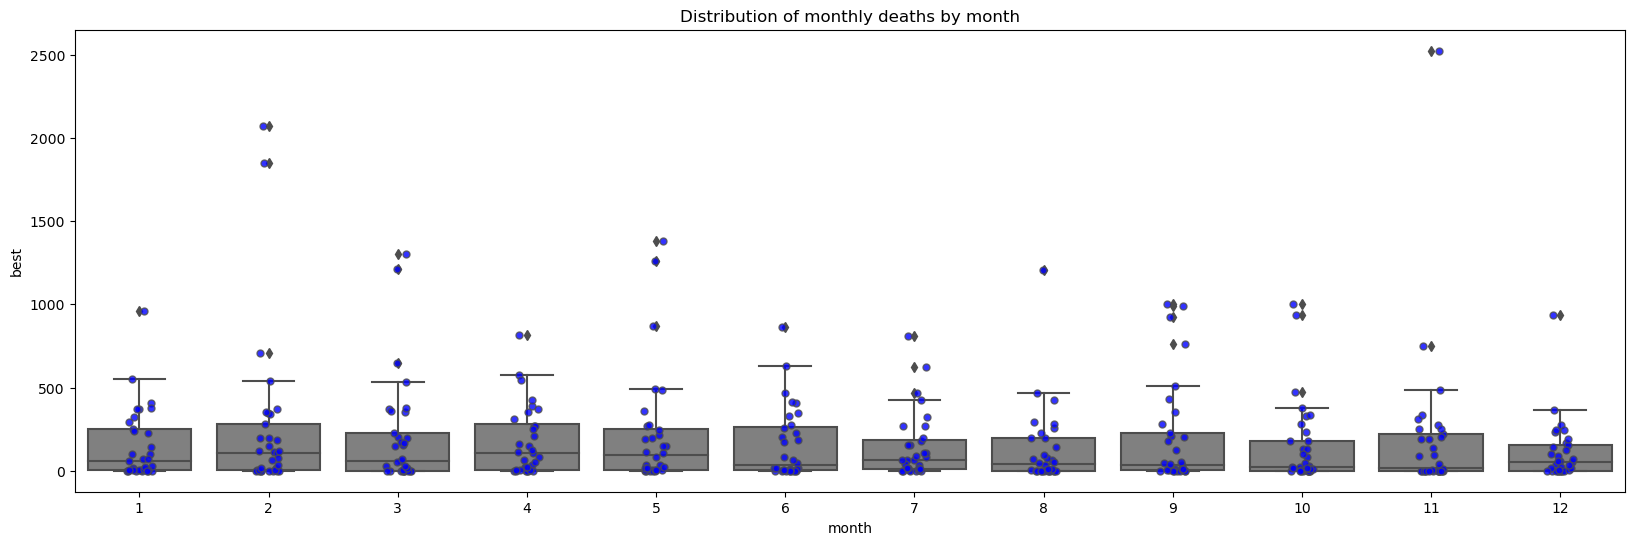

In [44]:
# No obvious trend or seasonality
for resolution in ['M', 'Q', 'Y']:
    fig, ax = plt.subplots(figsize=(20, 6))
    ucdp_nigeria_m['best'].resample(resolution).sum().iloc[1:-1].plot(ax=ax, marker='o')
    ax.set_title(f'deaths {resolution} resolution')


ucdp_nigeria_m['quarter'] = ucdp_nigeria_m.index.quarter
ucdp_nigeria_m['year'] = ucdp_nigeria_m.index.year
ucdp_nigeria_m['month'] = ucdp_nigeria_m.index.month
#consumption_agg['hour'] = consumption_agg.index.hour
#consumption_agg['day_of_week'] = consumption_agg.index.dayofweek
#consumption_agg['day_of_week_hour'] = consumption_agg.apply(lambda x: f'{x["day_of_week"]}_{x["hour"]}', axis=1)

time_features = [
    'quarter',
    'year',
    'month',
    #'hour',
    #'day_of_week',
    #'day_of_week_hour',
]
for f_name in time_features:
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.boxplot(x=f_name, y="best", data=ucdp_nigeria_m, ax=ax, color='grey')
    sns.stripplot(data=ucdp_nigeria_m, x=f_name, y='best', ax=ax, linewidth=1, color='b', alpha=.8)
    ax.set_title(f'Distribution of monthly deaths by {f_name}')


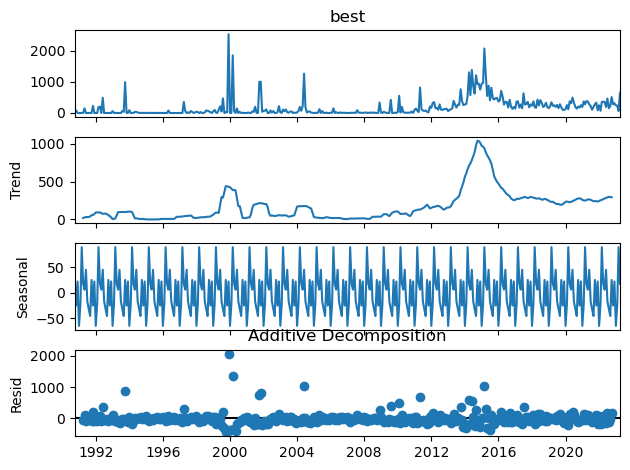

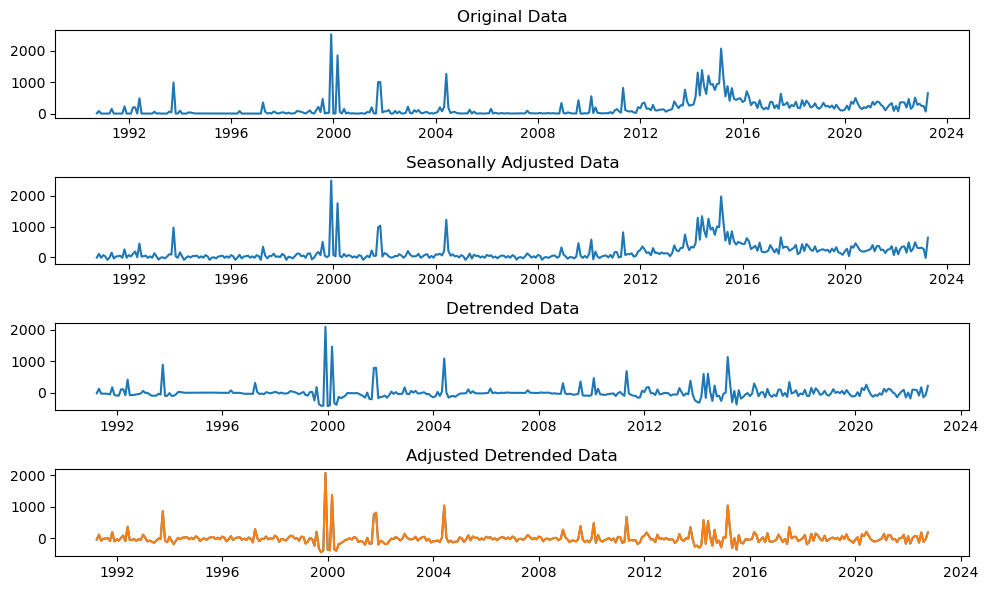

In [30]:
# Attempts to adjust for seasonality and trend in the data
# NB: Multiplicative seasonality is not appropriate for zero and negative values
decomposition = seasonal_decompose(ucdp_nigeria_m[TARGET], model='additive')

decomposition.plot()
plt.title("Additive Decomposition")
plt.show()

# Get the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Calculate the seasonally adjusted data
seasonally_adjusted = ucdp_nigeria_m[TARGET] - seasonal
detrended = ucdp_nigeria_m[TARGET] - trend
adjusted_detrended = ucdp_nigeria_m[TARGET] - trend - seasonal

# Versions if using the multiplicative model
# seasonally_adjusted = consumption_agg[TARGET] / seasonal
# detrended = consumption_agg[TARGET] / trend
# adjusted_detrended = consumption_agg[TARGET] / trend / seasonal

# Plotting the original and seasonally adjusted data
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(ucdp_nigeria_m[TARGET])
plt.title('Original Data')

plt.subplot(4, 1, 2)
plt.plot(seasonally_adjusted)
plt.title('Seasonally Adjusted Data')

plt.subplot(4, 1, 3)
plt.plot(detrended)
plt.title('Detrended Data')

plt.subplot(4, 1, 4)
plt.plot(adjusted_detrended)
plt.plot(residual) # Residuals are the same as adjusted detrended data 
plt.title('Adjusted Detrended Data')

plt.tight_layout()
plt.show()

# Modelling (only very rudimentary example for Nigeria)

In [ ]:
test_time = '2017-12-31'
#modelling_data = ucdp_nigeria_m[:test_time].copy()
modelling_data = ucdp_nigeria_m.copy()
train_df = modelling_data.loc[modelling_data.index < test_time]
#test_df = modelling_data.loc[test_time:]
test_df = modelling_data.loc[modelling_data.index >= test_time]

print(train_df.index.min(), train_df.index.max())
print(test_df.index.min(), test_df.index.max())

print(train_df.shape)
print(train_df.head())

print(test_df.shape)
print(test_df.head())

1990-09-30 00:00:00 2017-11-30 00:00:00
2017-12-31 00:00:00 2023-03-31 00:00:00
(327, 5)
            best        date  quarter  year  month
date_start                                        
1990-09-30     9  1990-09-30        3  1990      9
1990-10-31    80  1990-10-31        4  1990     10
1990-11-30     0  1990-11-30        4  1990     11
1990-12-31     0  1990-12-31        4  1990     12
1991-01-31     0  1991-01-31        1  1991      1
(64, 5)
            best        date  quarter  year  month
date_start                                        
2017-12-31   235  2017-12-31        4  2017     12
2018-01-31   375  2018-01-31        1  2018      1
2018-02-28   183  2018-02-28        1  2018      2
2018-03-31   168  2018-03-31        1  2018      3
2018-04-30   428  2018-04-30        2  2018      4


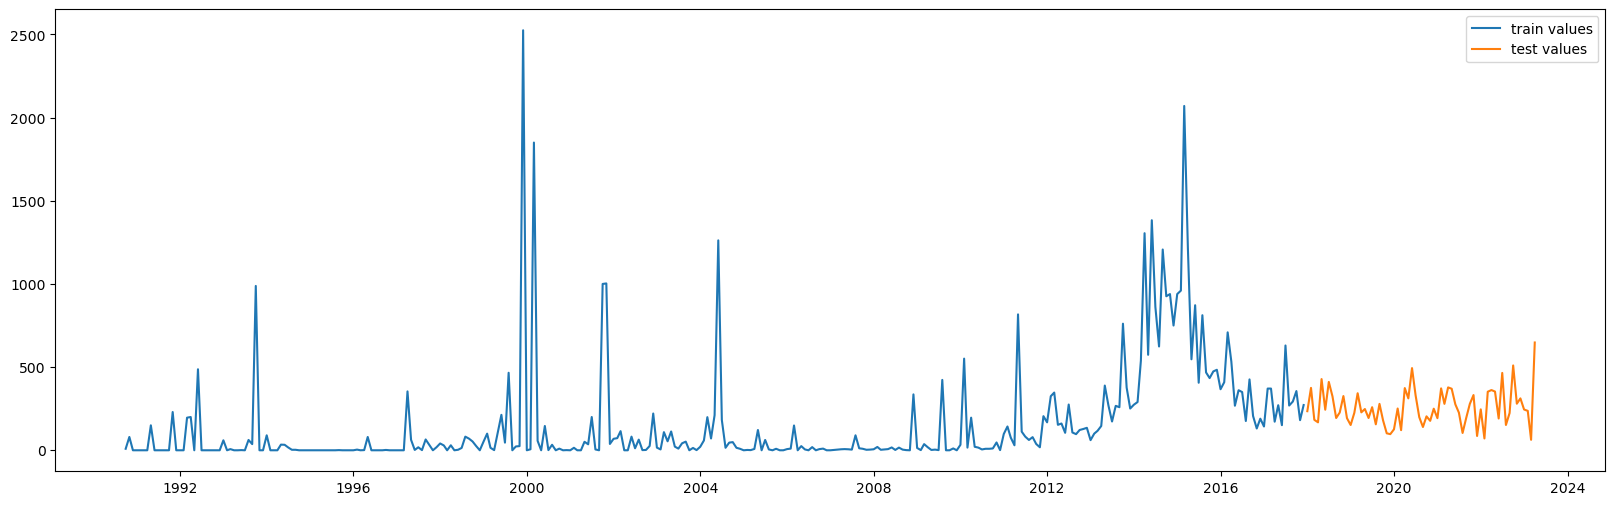

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(train_df['best'], label='train values') #.iloc[-300:]
ax.plot(test_df['best'], label='test values')
ax.legend()

### Naive: rolling mean

In [ ]:
losses = {}

In [ ]:
def plot_predictions(train_df, test_df, short_forecast, long_forecast=None, fitted=None, name=None, days_before=30):
    time_to_viz = pd.Timestamp(test_df.index.min()) - pd.Timedelta(days=days_before)
    real = pd.concat([train_df, test_df]).loc[time_to_viz:, 'best']
    fitted = fitted.loc[time_to_viz:] if fitted is not None else None
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(real, label='real values')
    if fitted is not None:
        ax.plot(fitted, label='fitted values')

    ax.plot(short_forecast, label='forecasted values (short)')
    if long_forecast is not None:
        ax.plot(long_forecast, label='forecasted values (long)')
    ax.set_title(name)
    ax.legend()
    return round(mean_absolute_error(test_df['best'], short_forecast), 2)

{'rolling_mean': 91.28}


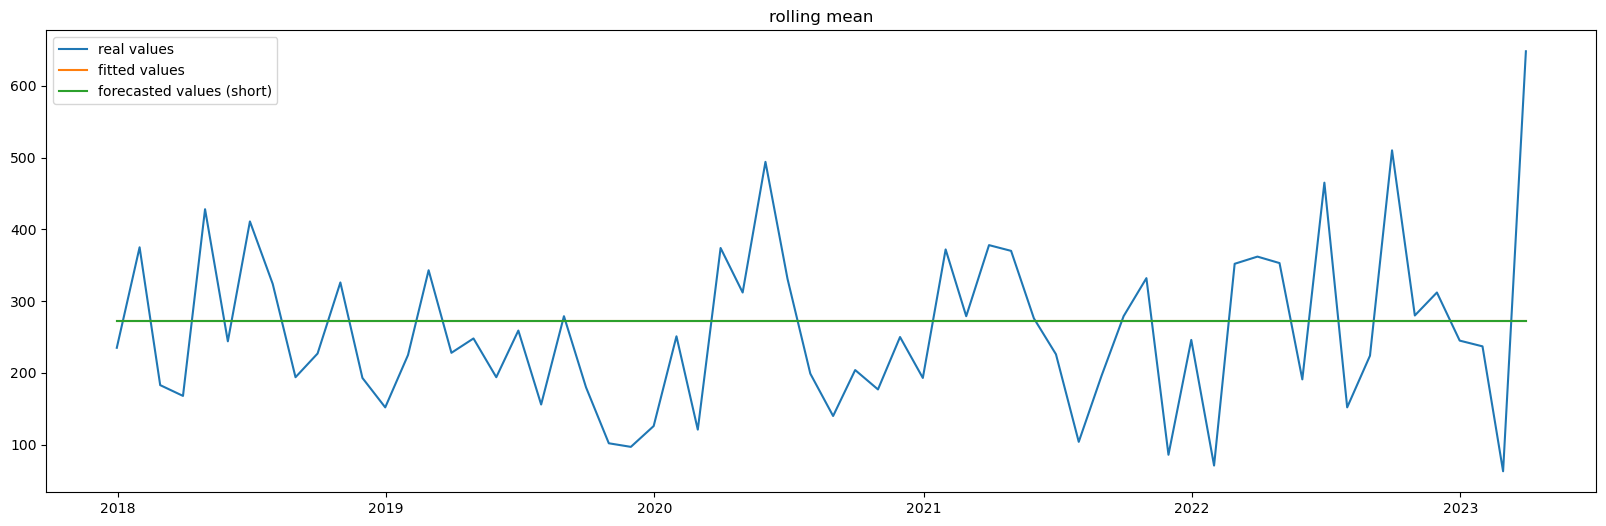

In [ ]:
window_size = 1  # was 5
fv = train_df.rolling(window=window_size)['best'].mean().values.tolist()
_train_df = train_df.copy()
for t in test_df.index:
    new_point = pd.DataFrame({'best': [fv[-1]]}, index=pd.DatetimeIndex([t], name='time'))
    _train_df = pd.concat([_train_df, new_point])
    fv = _train_df.rolling(window=window_size)['best'].mean()

#                    def plot_predictions(train_df, test_df, short_forecast, long_forecast=None, fitted=None, name=None, months_before=1):

losses['rolling_mean'] = plot_predictions(train_df, test_df, fv.iloc[-len(test_df):], None, fv, 'rolling mean')
print(losses)

rolling_mean             91.28
rolling_mean_monthly    100.31
dtype: float64


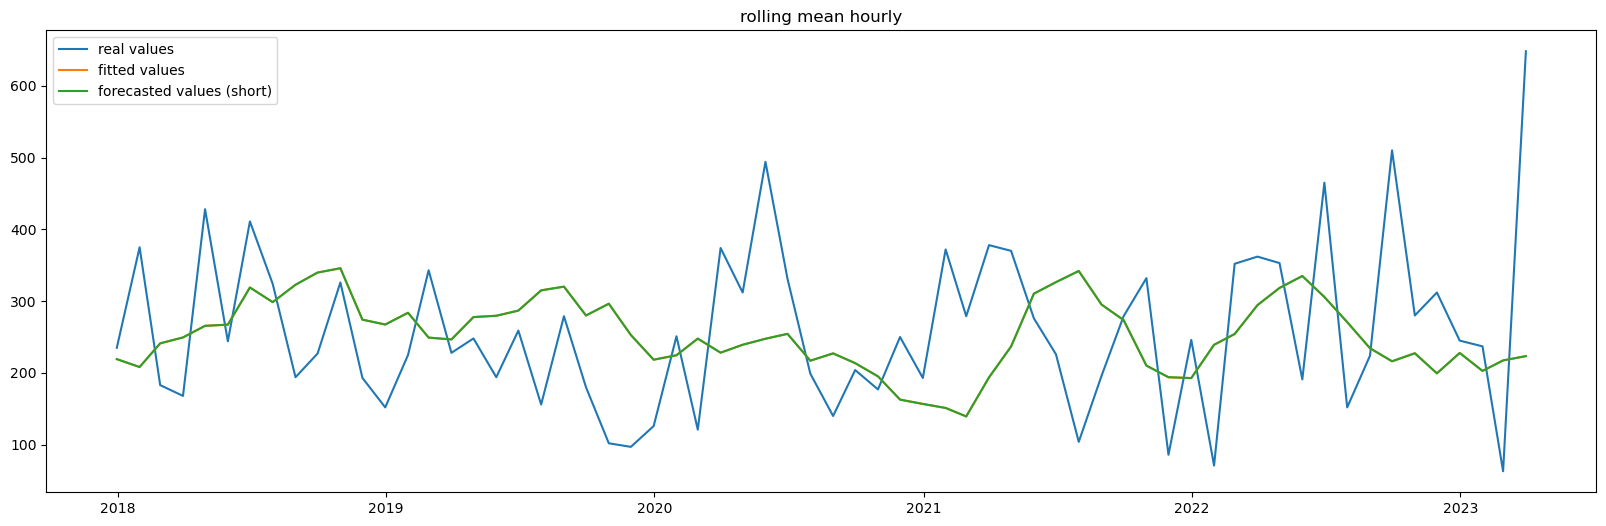

In [ ]:
# THIS CODE WILL NOT LEAK DATA
fv = pd.concat([train_df, test_df.assign(consumption=np.nan)]).sort_index()
fv = (
    fv.reset_index().set_index(['date_start', 'month'])
    .groupby("month").shift()["best"].reset_index(level=1)
    .rolling(window=5, min_periods=1)["best"]
    .mean()
    .sort_index()
)
losses['rolling_mean_monthly'] = plot_predictions(train_df, test_df, fv.iloc[-len(test_df):], None, fv, 'rolling mean hourly')
print(pd.Series(losses).sort_values())
# it seems to do better, it also seems like a more useful prediction
# what would happen if we'd need to extend the forecast N more days (e.g. 7 days)?

ValueError: Input contains NaN.

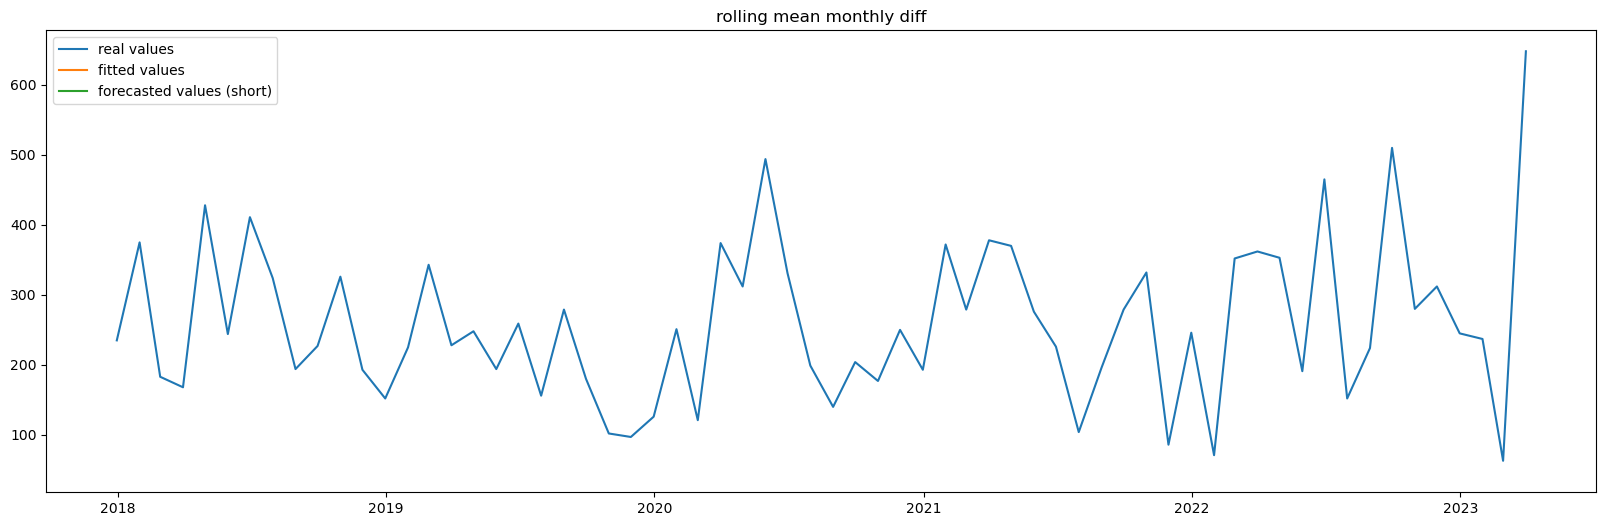

In [ ]:
import numpy as np
fv = pd.concat([train_df, test_df.assign(best=np.nan)]).sort_index()
fv = (
    fv.reset_index().set_index(['date_start', 'month'])
    .groupby("month").shift()["best"].reset_index().set_index(['date_start', 'month'])
    .groupby("month").diff()["best"].reset_index(level=1)
    .groupby('month').rolling(window=1, min_periods=1) #before was 5 (window)
    .mean()
    .reset_index(level=0)
    .sort_index()
)
#pre_diff_values = train_df.loc[train_df.index.isin(fv.iloc[:24].index), 'total_consumption']
# To revert the diff predictions to its original scale we just need to add the last known value to every prediction (the one before the diff)
# There are safer ways to do this, but this is the simplest one.
_train_df = train_df.copy()
_train_df.index = _train_df.index.shift(1, freq='M') # accepts month M
fv['best'] = fv['best'] + _train_df['best']
fv = fv['best']
losses['rolling_mean_monthly_diff'] = plot_predictions(train_df, test_df, fv.iloc[-len(test_df):], None, fv, 'rolling mean monthly diff', days_before=30)
print(pd.Series(losses).sort_values())
# Performance on test date is good, because the test day is very similar to the previous day.
# However if we were to evaluate on many days I suspect performance wouldn't be great

### ARIMA

In [ ]:
from sktime.forecasting.arima import ARIMA


arima = ARIMA(order=(1, 0, 0))

_train_df = train_df['total_consumption'].copy()
arima = arima.fit(_train_df)
arima.summary()

ModuleNotFoundError: No module named 'sktime'